<h1>Modeling - New car pricing</h1>

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as joblib
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.dummy import DummyRegressor
from datetime import datetime

<h2>Prepare Data for Modeling</h2>

In [9]:
# Load in data
df_cars = pd.read_csv('new_cars_cleaned_final.csv', low_memory = False)

In [11]:
# Split data into dependent and independent features, then perform train/test split
X = df_cars.drop(columns = 'MSRP')
y = df_cars['MSRP']

X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(X_Train.shape, X_Test.shape)
print(y_Train.shape, y_Test.shape)

X_Train.head()

(22583, 537) (9679, 537)
(22583,) (9679,)


,EPA Fuel Economy Est - City (MPG),Passenger Capacity,Passenger Doors,Base Curb Weight (lbs),Passenger Volume (ft³),Wheelbase (in),"Track Width, Front (in)","Height, Overall (in)","Fuel Tank Capacity, Approx (gal)",Max Torque,...,Engine Type_Missing,Engine Type_V10,Engine Type_V12,Engine Type_V6,Engine Type_V8,Engine Type_W12,Engine Compression_Missing,Engine Compression_NA/other,Engine Compression_Supercharged,Engine Compression_Turbocharged
30209,30.0,5,4,2970.0,94.7,105.7,60.7,57.4,13.2,184.0,...,0,0,0,0,0,0,0,0,0,1
2450,18.0,0,0,3500.5,97.5,111.5,61.6,65.5,19.0,260.0,...,1,0,0,0,0,0,1,0,0,0
6793,11.0,12,3,3500.5,97.5,155.0,61.6,82.8,31.0,373.0,...,0,0,0,0,1,0,0,1,0,0
1504,20.0,2,2,3131.0,58.9,95.4,60.0,53.0,14.5,173.0,...,0,0,0,0,0,0,0,1,0,0
28338,17.0,5,2,3500.5,97.5,121.9,61.6,67.1,18.0,220.0,...,0,0,0,1,0,0,0,1,0,0


In [19]:
y_Test.head()

24651    74970.0
20075    18550.0
7221     29255.0
26778    20695.0
10520    39105.0
Name: MSRP, dtype: float64

In [12]:
# Scale features before modeling
scaler = StandardScaler()

scaler.fit(X_Train)
X_Train_scaled = scaler.transform(X_Train)
X_Test_scaled = scaler.transform(X_Test)

<h2>Simple Model using Average for comparison</h2>

In [14]:
# Use Dummy Regressor to use mean of train values for comparison to other models
dummy_regr = DummyRegressor(strategy = 'mean')
dummy_regr.fit(X_Train_scaled, y_Train)
dummy_regr.constant_

array([[37649.37165124]])

In [17]:
# Calculate metrics on predictions of Dummy model
y_Test_pred_dummy = dummy_regr.predict(X_Test_scaled)

r2_dummy = r2_score(y_Test, y_Test_pred_dummy)
mae_dummy = mean_absolute_error(y_Test, y_Test_pred_dummy)
mse_dummy = mean_squared_error(y_Test, y_Test_pred_dummy)

print('Simple Dummy Regressor Model R^2: {}'.format(r2_dummy))
print("Simple Dummy Regressor Model MAE: {}".format(mae_dummy))
print("Simple Dummy Regressor Model MSE: {}".format(mse_dummy))

Simple Dummy Regressor Model R^2: -3.40437782107017e-05
Simple Dummy Regressor Model MAE: 16796.45500789669
Simple Dummy Regressor Model MSE: 1101204823.400618


We can clearly see the Dummy Regressor doesn't work particularly well on the test set by the metrics above. We will use it simply as a point of comparison to our actual models.

<h2>Linear Regression Models</h2>

<h3>Simple Linear Regression Model</h3>

In [20]:
# First we try a Linear Regression model using default parameters
lreg_model = LinearRegression()
lreg_model.fit(X_Train_scaled, y_Train)

y_Train_pred = lreg_model.predict(X_Train_scaled)
y_Test_pred = lreg_model.predict(X_Test_scaled)

In [22]:
# Compute metrics in next few cells as well as perform cross validation
r2_lreg = r2_score(y_Test, y_Test_pred)
print('Linear Regression Model R^2: {}'.format(r2_lreg))

Linear Regression Model R^2: -8.073250978122884e+22


In [23]:
r2_score(y_Train, y_Train_pred)

0.9570241354691773

In [24]:
mae_lreg_model = mean_absolute_error(y_Train, y_Train_pred), mean_absolute_error(y_Test, y_Test_pred)
mae_lreg_model

(3512.8081652226947, 100850168165670.17)

In [104]:
cross_val_score_lreg = cross_val_score(lreg_model, X_Train_scaled, y_Train, cv = 10)
cross_val_score_lreg

array([ 9.50787179e-01,  9.54386925e-01,  9.26534026e-01,  9.44465619e-01,
       -4.46068515e+24, -3.09224707e+24, -2.73258569e+23, -9.51180361e+23,
       -3.83334712e+24, -9.86346827e+24])

Obviously the Linear Regression default model doesn't perform very well on the test data as seen by the large MAE and R^2 value far from 1. Also the cross validation scores indicate a very large variance.  Let's move on and try and make a better Linear Regression model with hyperparameter tuning.

<h3>Linear Regression Tuned Models</h3>

In [42]:
# Lets use a pipeline with selectkbest in its default form and see if we can get Linear Regression to perform better. 
np.seterr(divide='ignore', invalid='ignore')

pipe = make_pipeline(SelectKBest(f_regression), LinearRegression())

pipe.fit(X_Train_scaled, y_Train)

y_Train_pred_lreg2 = pipe.predict(X_Train_scaled)
y_Test_pred_lreg2 = pipe.predict(X_Test_scaled)


In [26]:
# Calculate R^2 scores
print("Linear Regression selectKBest model R^2 score train: {}".format(r2_score(y_Train, y_Train_pred_lreg2)))
print("Linear Regression selectKBest model R^2 score test: {}".format(r2_score(y_Test, y_Test_pred_lreg2)))

Linear Regression selectKBest model R^2 score train: 0.8038727596332061
Linear Regression selectKBest model R^2 score test: 0.8150740736277162


Interestingly the model actually performs better, in terms of R^2 score, on the test data then the train data.  That is quite surprising and unusual, though it is possible.

In [27]:
# Calculate other evaluation metrics on test set
r2_lreg2 = r2_score(y_Test, y_Test_pred_lreg2)
mae_lreg2 = mean_absolute_error(y_Test, y_Test_pred_lreg2)
mse_lreg2 = mean_squared_error(y_Test, y_Test_pred_lreg2)

print("Linear Regression selectKBest model MAE: {}".format(mae_lreg2))
print("Linear Regression selectKBest model MSE: {}".format(mse_lreg2))

Linear Regression selectKBest model MAE: 8820.441553901946
Linear Regression selectKBest model MSE: 203634389.6089905


In [106]:
# Perform cross validation to check variance
lreg_selectkbest_cv_scores = cross_val_score(pipe, X_Train_scaled, y_Train, cv = 5)
lreg_selectkbest_cv_scores

array([0.80477974, 0.74241486, 0.81487109, 0.79740316, 0.82248045])

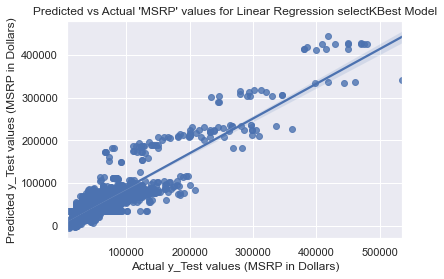

In [28]:
# Plot predicted vs actual target test values (car MSRP) for the model
sns.set_theme()
_ = sns.regplot(x = y_Test, y = y_Test_pred_lreg2)
plt.xlabel('Actual y_Test values (MSRP in Dollars)')
plt.ylabel('Predicted y_Test values (MSRP in Dollars)')
plt.title("Predicted vs Actual 'MSRP' values for Linear Regression selectKBest Model")
plt.show()

In [61]:
# Now lets do a GridSearch to find best K value for Linear Regression model
k_values = [k+1 for k in range(50)]
params = {'selectkbest__k': k_values}

lreg_model_grid = GridSearchCV(pipe, param_grid=params, cv=5)

lreg_model_grid.fit(X_Train_scaled, y_Train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001C4D55C89D0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [107]:
# Calculate metrics of GridSearchCV best estimator for Linear Regression model
y_pred_lreg_grid = lreg_model_grid.predict(X_Test_scaled)

r2_lreg_grid = r2_score(y_Test, y_pred_lreg_grid)
mae_lreg_grid = mean_absolute_error(y_Test, y_pred_lreg_grid)
mse_lreg_grid = mean_squared_error(y_Test, y_pred_lreg_grid)

print('Linear Regression GridSearchCV Best K: {}'.format(lreg_model_grid.best_params_))
print('Linear Regression GridSearchCV R squared: {}'.format(r2_lreg_grid))
print('Linear Regression GridSearchCV MAE: {}'.format(mae_lreg_grid))
print('Linear Regression GridSearchCV MSE: {}'.format(mse_lreg_grid))

Linear Regression GridSearchCV Best K: {'selectkbest__k': 50}
Linear Regression GridSearchCV R squared: 0.8965461338618224
Linear Regression GridSearchCV MAE: 6490.20935537878
Linear Regression GridSearchCV MSE: 113920018.12297241


In [64]:
y_pred_lreg_grid

array([92604.8975372 , 14175.08703663, 24001.14684716, ...,
       10995.12653302, 46399.59150231, 14311.25168081])

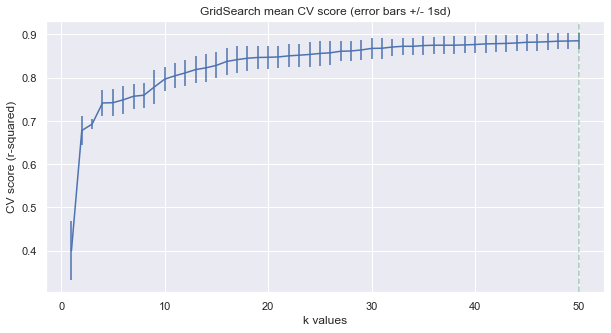

In [67]:
# Create plot of CV test scores of GridSearch
r2_mean = lreg_model_grid.cv_results_['mean_test_score']
r2_std = lreg_model_grid.cv_results_['std_test_score']
cv_k = [k for k in lreg_model_grid.cv_results_['param_selectkbest__k']]

best_k = lreg_model_grid.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, r2_mean, yerr= r2_std)
plt.axvline(x=best_k, c='g', ls='--', alpha=.5)
plt.xlabel('k values')
plt.ylabel('CV score (r-squared)')
plt.title('GridSearch mean CV score (error bars +/- 1sd)');

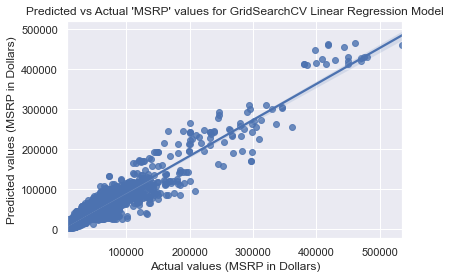

In [66]:
# Plot predictions vs actual values using best Linear Model (GridSearchCV best estimator)
_ = sns.regplot(x = y_Test, y = y_pred_lreg_grid)
plt.xlabel('Actual values (MSRP in Dollars)')
plt.ylabel('Predicted values (MSRP in Dollars)')
plt.title("Predicted vs Actual 'MSRP' values for GridSearchCV Linear Regression Model")
plt.show()

Text(0.5, 1.0, 'Best Linear Regression Model feature importances')

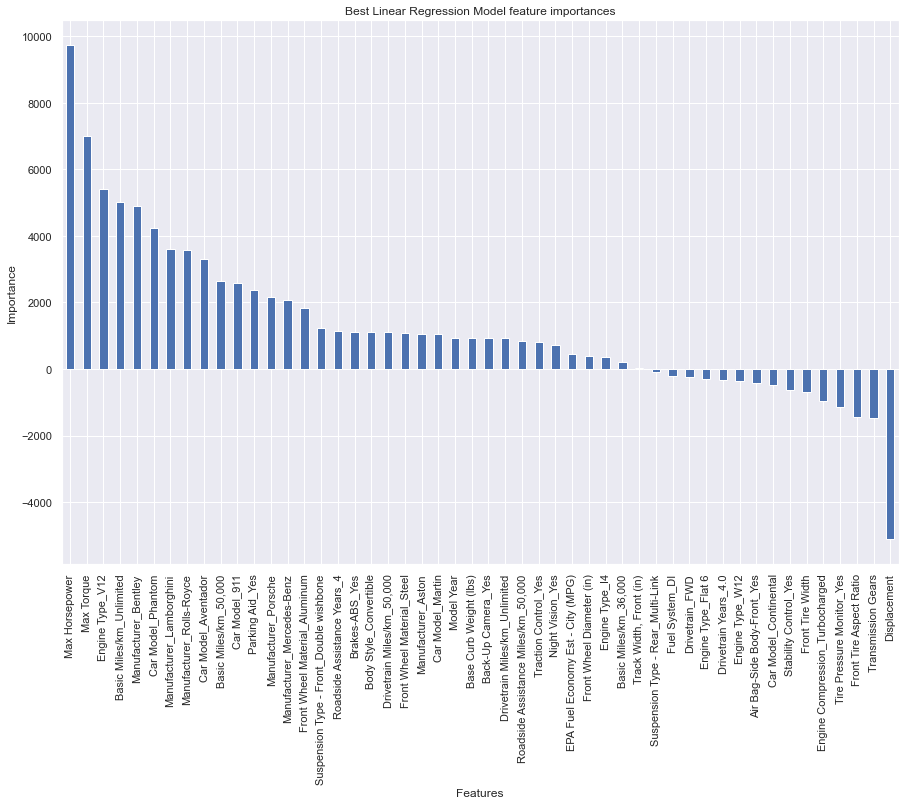

In [73]:
# Plot the feature importances of the model
plt.subplots(figsize=(15, 10))
selected_features = lreg_model_grid.best_estimator_.named_steps.selectkbest.get_support()
lreg_features = X_Train.columns[selected_features]
lreg_coef = lreg_model_grid.best_estimator_.named_steps.linearregression.coef_
lreg_feat_imps = pd.Series(lreg_coef, index=lreg_features).sort_values(ascending=False)
lreg_feat_imps.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Best Linear Regression Model feature importances')

Quite an interesting result.  Most of the more important features in the model make sense intuitively (max hp, max torque, various manufacturers often associated with higher prices) but there are some surprises.  I am very surprised to see Displacement and transmission gears at the bottom for example.  Displacement in particular I would strongly have suspected to be quite strongly correlated with higher prices.

# Elastic Net Model

In [74]:
# Now we will try and Elastic Net model
elastic_net = ElasticNet(max_iter = 3000, random_state = 30)
elastic_net.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 3000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 30,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [75]:
# Lets use a GridSearch to find best L1 ratio value, the key Elastic Net hyperparameter

l1_values = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_values}

en_model = GridSearchCV(elastic_net, param_grid, cv = 5)
en_model.fit(X_Train_scaled, y_Train)



C:\Users\Michael\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1995533067515.9043, tolerance: 1895635668.1500473
  model = cd_fast.enet_coordinate_descent(
C:\Users\Michael\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1977698039430.6104, tolerance: 1947942079.0130863
  model = cd_fast.enet_coordinate_descent(
C:\Users\Michael\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1935376632567.2417, tolerance: 1752941131.4903305
  model = cd_fast.enet_coordinate_descent(
C:\Users\Michael\Documents\Anaconda3\lib\site-packages\sklearn\line

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=3000, random_state=30),
             param_grid={'l1_ratio': array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
       0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
       0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
       0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
       0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
       0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ])})

In [76]:
# Evaluate ElasticNet model on test set, and check metrics
y_pred_en = en_model.predict(X_Test_scaled)

r2_en = en_model.score(X_Test_scaled, y_Test)
mae_en = mean_absolute_error(y_Test, y_pred_en)
mse_en = mean_squared_error(y_Test, y_pred_en)

print("ElasticNet model l1 ratio: {}".format(en_model.best_params_))
print("ElasticNet model R squared: {}".format(r2_en))
print("ElasticNet model MAE: {}".format(mae_en))
print("ElasticNet model MSE: {}".format(mse_en))

ElasticNet model l1 ratio: {'l1_ratio': 1.0}
ElasticNet model R squared: 0.9580955420489701
ElasticNet model MAE: 3630.0671923049167
ElasticNet model MSE: 46143820.307678185


In [77]:
en_model.cv_results_['mean_test_score']

array([0.89975956, 0.90161022, 0.90345729, 0.90530008, 0.90713769,
       0.90896959, 0.91079488, 0.91261262, 0.9144218 , 0.91622143,
       0.91801047, 0.91978779, 0.92155221, 0.92330261, 0.92503772,
       0.92675626, 0.92845739, 0.93014004, 0.93180345, 0.93344758,
       0.93507315, 0.93668229, 0.93827838, 0.93987007, 0.94146831,
       0.94309741, 0.94479473, 0.94662585, 0.94866153, 0.95146952])

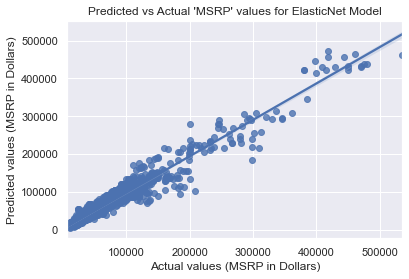

In [78]:
# Once again plot predicted vs actual values of MSRP on test set for the model
sns.set_theme()
_ = sns.regplot(x = y_Test, y = y_pred_en)
plt.xlabel('Actual values (MSRP in Dollars)')
plt.ylabel('Predicted values (MSRP in Dollars)')
plt.title("Predicted vs Actual 'MSRP' values for ElasticNet Model")
plt.show()

Text(0.5, 1.0, 'Elastic Net model feature importances')

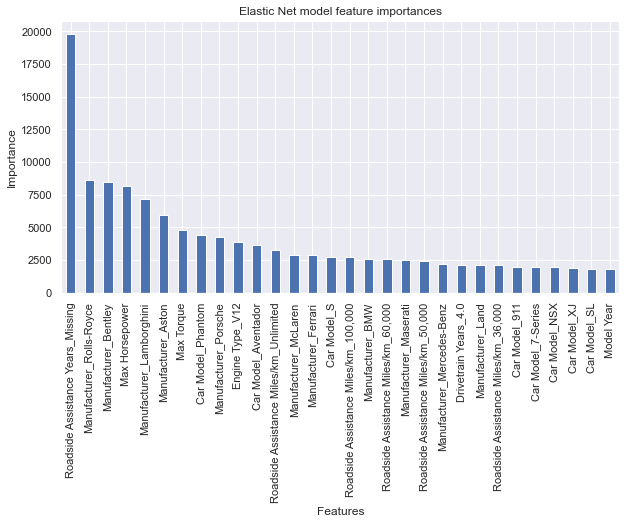

In [108]:
# Let's look at the feature importances of the Elastic Net model
plt.subplots(figsize=(10, 5))
en_imps = en_model.best_estimator_.coef_
en_feat_imps = pd.Series(en_imps, index=X_Train.columns).sort_values(ascending=False)
en_feat_imps_slice = en_feat_imps[:30]
en_feat_imps_slice.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Elastic Net model feature importances')

Very odd feature at the top of feature importances here.  Hard to know why, maybe many expensive cars in train set simply had a missing value for Roadside assistance years while less expensive cars did not.  The rest of the features importances here make sense though.

# Random Forest Regressor Model

<h3>Default Random Forest Regressor Model</h3>

In [79]:
# Finally lets try a RandomForest Regressor Model using default parameters

rf = RandomForestRegressor(random_state = 42)

rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [81]:
# Fit and predict using Random Forest model, and check out evaluation metrics
time1 = datetime.now()
rf_model = rf.fit(X_Train_scaled, y_Train)
time2 = datetime.now() - time1
y_pred_rf = rf_model.predict(X_Test_scaled)
print(time2)

r2_rf = rf_model.score(X_Test_scaled, y_Test)
mae_rf = mean_absolute_error(y_Test, y_pred_rf)
mse_rf = mean_squared_error(y_Test, y_pred_rf)

print("Random Forest Regressor model R squared: {}".format(r2_rf))
print("Random Forest Regressor model MAE: {}".format(mae_rf))
print("Random Forest Regressor model MSE: {}".format(mse_rf))


0:00:59.482321
Random Forest Regressor model R squared: 0.9866949806553114
Random Forest Regressor model MAE: 1587.0365477488106
Random Forest Regressor model MSE: 14651052.700620973


In [111]:
cross_val_score_rf = cross_val_score(rf, X_Train_scaled, y_Train, cv = 5)
cross_val_score_rf_mean = np.mean(cross_val_score_rf)
cross_val_score_rf_std = np.std(cross_val_score_rf)

print("Random Forest Regressor Model cross val scores: {}".format(cross_val_score_rf))
print("Random Forest Regressor Model cross val score mean: {}".format(cross_val_score_rf_mean))
print("Random Forest Regressor Model cross val score std: {}".format(cross_val_score_rf_std))


Random Forest Regressor Model cross val scores: [0.98407151 0.97795329 0.98527003 0.98171659 0.98264882]
Random Forest Regressor Model cross val score mean: 0.9823320498412329
Random Forest Regressor Model cross val score std: 0.0025024054506047337


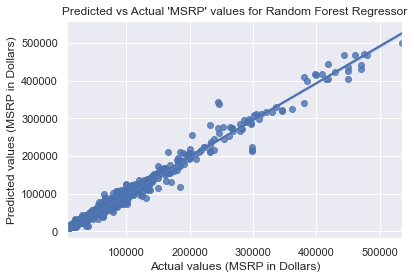

In [82]:
# Plot predicted vs actual values of Random Forest model
_ = sns.regplot(x = y_Test, y = y_pred_rf)
plt.xlabel('Actual values (MSRP in Dollars)')
plt.ylabel('Predicted values (MSRP in Dollars)')
plt.title("Predicted vs Actual 'MSRP' values for Random Forest Regressor")
plt.show()

We can see the Random Forest Regressor Model performs very well on the test set looking at both the metrics and at the plot above.  It clearly outperforms our other models.  While it seems a bit unlikely, let us see if we can improve the model at all with hyperparameter optimizations.

<h3>Hyperparameter search for Random Forest Regressor Model</h3>

In [83]:
# We will start with a GridSearch of the n_estimator hyperparameter, followed by a RandomizedSearch over other hyperparameters

n_est = [100, 200, 300, 400, 500, 600, 700]

param_grid = {'n_estimators': n_est}


In [84]:
# Perform GridSearch over n_estimator hyperparameter space

rfr = RandomForestRegressor(random_state = 20)

time_1 = datetime.now()
rf_gridCV = GridSearchCV(rfr, param_grid, cv = 3, n_jobs = -1)
rf_gridCV.fit(X_Train_scaled, y_Train)
time_2 = datetime.now() - time_1

print('Time taken for search was (hh:mm:ss.ms): {}'.format(time_2))


Time taken for search was (hh:mm:ss.ms): 0:21:59.036652


In [85]:
print('Random Forest best number of estimators: {}'.format(rf_gridCV.best_params_))

Random Forest best number of estimators: {'n_estimators': 700}


In [86]:
# Now lets use RandomizedSearchCV to try and find optimal hyperparameters, many iterations and tests were done to try and chose
# which hyperparameters to test and how large of spaces to choose for each

bootstraps = [True, False]
max_dept = [10, 20, 30, 50, 70, 100, None]
max_feat = ['auto', 'sqrt']
min_samp_leaf = [1, 2, 3]
min_samp_split = [2, 3, 4]

param_grid_2 = {'bootstrap': bootstraps,
              'max_depth': max_dept,
              'max_features': max_feat,
              'min_samples_leaf': min_samp_leaf,
              'min_samples_split': min_samp_split}

rfr_2 = RandomForestRegressor(n_estimators = 700, random_state = 25)

time_3 = datetime.now()

rf_randomCV = RandomizedSearchCV(rfr_2, param_grid_2, n_iter = 50, cv = 3, n_jobs = -1 , random_state = 45)
rf_randomCV.fit(X_Train_scaled, y_Train)

time_4 = datetime.now()

print('Time taken for search was (hh:mm:ss.ms): {}'.format(time_4))

Time taken for search was (hh:mm:ss.ms): 2021-09-09 16:54:10.681733


In [87]:
# lets look at best parameters from Random Search
print("Random Forest RandomSearchCV best params: {}".format(rf_randomCV.best_params_))

Random Forest RandomSearchCV best params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}


In [88]:
# Calculate evaluation metrics using best_estimator_ from Random Search
y_pred_rf_randomCV = rf_randomCV.best_estimator_.predict(X_Test_scaled)
r2_rf_randomCV = rf_randomCV.score(X_Test_scaled, y_Test)
mae_rf_randomCV = mean_absolute_error(y_Test, y_pred_rf_randomCV)
mse_rf_randomCV = mean_squared_error(y_Test, y_pred_rf_randomCV)

print("Random Forest Regressor RandomCV model R squared: {}".format(r2_rf_randomCV))
print("Random Forest Regressor RandomCV model MAE: {}".format(mae_rf_randomCV))
print("Random Forest Regressor RandomCV model MSE: {}".format(mse_rf_randomCV))

Random Forest Regressor RandomCV model R squared: 0.9868122745760178
Random Forest Regressor RandomCV model MAE: 1574.8166149817712
Random Forest Regressor RandomCV model MSE: 14521892.466485841


In [89]:
# Perform cross validation on Random Search best_estimator_
rf_randomCV_cv_results = cross_validate(rf_randomCV.best_estimator_, X_Train_scaled, y_Train, cv=5)
rf_randomCV_cv_scores = rf_randomCV_cv_results['test_score']

rf_randomCV_test_score_mean = np.mean(rf_randomCV_cv_scores)
rf_randomCV_test_score_std = np.std(rf_randomCV_cv_scores)

print("Random Forest RandomCV model CV test scores: {}".format(rf_randomCV_cv_scores))
print("Random Forest RandomCV model CV scores mean: {}".format(rf_randomCV_test_score_mean))
print("Random Forest RandomCV model CV score std: {}".format(rf_randomCV_test_score_std))

Random Forest RandomCV model CV test scores: [0.98418094 0.97878419 0.98523802 0.98234807 0.98305997]
Random Forest RandomCV model CV scores mean: 0.982722239747992
Random Forest RandomCV model CV score std: 0.0022008772020958036


So the hyperparameter tuned Random Forest Regressor model doesn't really perform any better than the default Random Forest Regressor model.  They have essentially identical performance on the test set and cross validation also yields nearly the same for each.

Text(0.5, 1.0, 'Random Forest Regressor model feature importances')

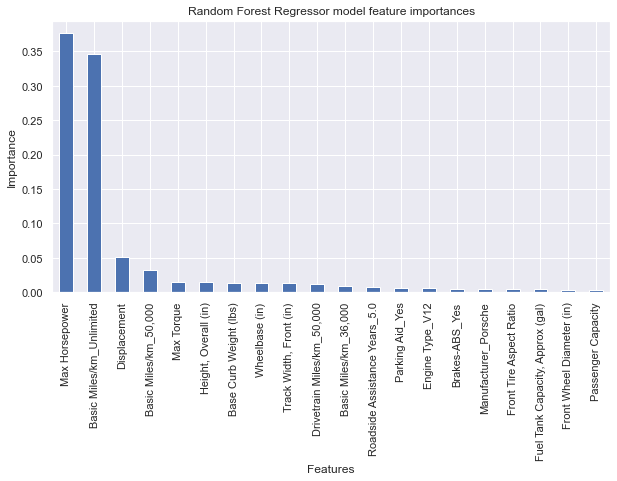

In [113]:
# Let us plot the feature importances of the default Random Forest Regressor Model
plt.subplots(figsize=(10, 5))
rf_imps = rf_model.feature_importances_
rf_feat_imps = pd.Series(rf_imps, index=X_Train.columns).sort_values(ascending=False)
rf_feat_imps_slice = rf_feat_imps[:20]
rf_feat_imps_slice.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Regressor model feature importances')

The Random Forest Regressor model yields interesting feature importances.  Two features dominate, max horsepower and Basic miles/km unlimited (unlimited mileage under warranty).  Max horsepower makes sense but basic miles unlimited is somewhat surprising.  

<h2>Final Model Selection</h2>

We tried quite a few different models.  The three primary types were Linear Regression, Elastic Net and Random Forest Regression.  But at the end of the day the Random Forest Regressor clearly performed best across all our evaluation metrics.
We tried to optimize parameters of the Random Forest Regressor model but it proved to be virtually indistinguishable from the default model while taking many hours to compute.  It doesn't make sense to use a model that performs negligibly better than one that is simpler and that is much faster.  So by that logic I believe the best model to use to predict our target variable (car MSRP) is the default Random Forest Regressor.

In [122]:
# Save model, and versions just in case

best_model_cars = rf_model
best_model_cars.version = '1.0'
best_model_cars.pandas_version = pd.__version__
best_model_cars.numpy_version = np.__version__
best_model_cars.sklearn_version = sklearn_version
best_model_cars.build_datetime = datetime.now()

joblib_file = "joblib_best_model_new_cars.pkl"
joblib.dump(best_model_cars, joblib_file)

['joblib_best_model_new_cars.pkl']